In [3]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.tensorboard import SummaryWriter
from utils import plot_confusion_matrix
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

C:\Users\Sneha\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
hparams = {    
    'dataset': 'data/prepared_data_balanced.csv',
    'epochs': 15,
    'batch_size': 16,
    'lr': 1e-3,
    'features': [
        'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate',
        'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 
        'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20'
    ]
}

In [5]:
df_features = pd.read_csv(hparams['dataset'])
X = np.array(df_features[hparams['features']], dtype=np.float32)
encoder = LabelEncoder()
y = encoder.fit_transform(df_features['label'])
print('classes:', encoder.classes_)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
torch.manual_seed(42)
train_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train).long())
test_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test).long())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=hparams['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=hparams['batch_size'], shuffle=False)

classes: ['covid' 'not_covid']
X_train.shape: (107, 26)
y_train.shape: (107,)


In [6]:
class CoughNet(torch.nn.Module):
    def __init__(self, input_size):
        super(CoughNet, self).__init__()
        self.l1 = torch.nn.Linear(input_size, 512)
        self.l2 = torch.nn.Linear(512, 256)
        self.l3 = torch.nn.Linear(256, 128)
        self.l4 = torch.nn.Linear(128, 64)
        self.l5 = torch.nn.Linear(64, 10)
        self.l6 = torch.nn.Linear(10, 2)
    def forward(self, x):
        x = torch.relu(self.l1(x))
        x = torch.relu(self.l2(x))
        x = torch.relu(self.l3(x))
        x = torch.relu(self.l4(x))
        x = torch.relu(self.l5(x))
        x = self.l6(x)
        return x
model = CoughNet(len(hparams['features'])).to(device)

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=hparams['lr'])
criterion = torch.nn.CrossEntropyLoss()
def train(loader_train, model, optimizer, epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0.0
    total = 0
    pbar = tqdm(enumerate(loader_train), total=len(loader_train))
    for batch_ndx, sample in pbar: 
        features, labels = sample[0].to(device), sample[1].to(device) 
        outputs = model(features)
        loss = criterion(outputs, labels)      
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()
        predictions = torch.argmax(outputs.data, 1)
        running_correct += (predictions == labels).sum().item()
        pbar.set_description(f'[Training Epoch {epoch+1}]') 
        total += labels.shape[0]
        pbar.set_postfix({'loss': running_loss / total, 'train_accuracy': running_correct / total})
    writer.add_scalar('Loss/Train', running_loss / total, epoch+1)
    writer.add_scalar('Accuracy/Train', running_correct / total, epoch+1)
def evaluate(loader_test, model, epoch):
    model.eval()
    running_loss = 0.0
    running_correct = 0.0
    total = 0
    with torch.no_grad():
        pbar = tqdm(enumerate(loader_test), total=len(loader_test))
        for batch_ndx, sample in pbar:
            features, labels = sample[0].to(device), sample[1].to(device) 
            outputs = model(features)
            loss = criterion(outputs, labels)  
            running_loss += loss.item()
            predictions = torch.argmax(outputs.data, 1)
            running_correct += (predictions == labels).sum().item()
            pbar.set_description(f'[Evaluating Epoch {epoch+1}]')
            total += labels.shape[0]
            pbar.set_postfix({'loss': running_loss / total, 'eval_accuracy': running_correct / total})
    writer.add_scalar('Loss/Eval', running_loss / total, epoch+1)
    writer.add_scalar('Accuracy/Eval', running_correct / total, epoch+1)
time_stamp = datetime.now().strftime('%Y%m%d-%H%M%S')
writer = SummaryWriter(f'logs/{time_stamp}/')
for features, _ in test_loader:
    writer.add_graph(model, features)
    break  
for epoch in range(hparams['epochs']):
    train(train_loader, model, optimizer, epoch)
    evaluate(test_loader, model, epoch)
writer.close()

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

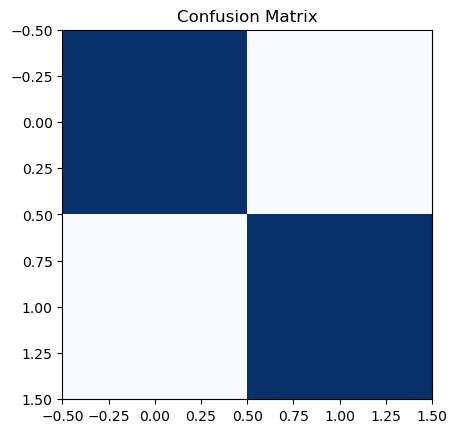

In [10]:
def inference(loader_test, model):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for features, labels in loader_test:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            predicted = torch.argmax(outputs, dim=1)
            predictions.extend(predicted.tolist())
            targets.extend(labels.tolist())
    return predictions, targets
predictions, targets = inference(test_loader, model)
plot_confusion_matrix(targets, predictions, encoder.classes_)

In [ ]:
checkpoint = {
    'hparams': hparams,
    'model_state': model.state_dict(),
    'scaler': scaler,
    'encoder': encoder
}
torch.save(checkpoint, 'checkpoints/checkpoint.pth')

In [11]:
predictions = np.array(predictions)
targets = np.array(targets)
accuracy = (predictions == targets).mean()
print(f"Accuracy: {accuracy}")

Accuracy: 1.0
